# Load dependences and file

In [54]:
from gendesc import getmorganfp
from mlutils import process_desc
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib notebook

In [30]:
with open('./data/re_smi_metal.csv','r') as fr:
    lines = fr.readlines()[1:]
tot_re_smi = [tmp_line.strip().split(',')[0] for tmp_line in lines]
tot_metals = [tmp_line.strip().split(',')[1] for tmp_line in lines]

tot_re_smi_set = sorted(list(set(tot_re_smi)))
tot_metals_set = sorted(list(set(tot_metals)))

print('There are %d olefins total'%len(tot_re_smi_set))

There are 2754 olefins total


Convert reactant SMILES to Mol objects, then use "getmorganfp" function to convert Mol object into Morgan Fingerprints.

In [28]:
tot_re_mols = [Chem.MolFromSmiles(tmp_smi) for tmp_smi in tot_re_smi_set]
tot_re_mf = np.array([getmorganfp(tmp_mol) for tmp_mol in tot_re_mols])

In [29]:
target_smi = 'COC(=O)/C(=C/c1ccccc1)NC(C)=O'

related_set_a_smi = []
related_set_b_smi = []

for tmp_smi,tmp_m in zip(tot_re_smi,tot_metals):
    if tmp_smi == target_smi or tmp_m != 'Rh':
        continue
    if not Chem.MolFromSmiles(tmp_smi).HasSubstructMatch(Chem.MolFromSmiles('COC(C(NC(C)=O)=C)=O')) and \
       not Chem.MolFromSmiles(tmp_smi).HasSubstructMatch(Chem.MolFromSmiles('O=C(/C=C/C1=CC=CC=C1)OC')) and \
       not Chem.MolFromSmiles(tmp_smi).HasSubstructMatch(Chem.MolFromSmiles('O=C(C)N/C=C\c1ccccc1')):
        if Chem.MolFromSmiles(tmp_smi).HasSubstructMatch(Chem.MolFromSmiles('C=CNC(C)=O')) or \
           Chem.MolFromSmiles(tmp_smi).HasSubstructMatch(Chem.MolFromSmiles('C=Cc1ccccc1')) or \
           Chem.MolFromSmiles(tmp_smi).HasSubstructMatch(Chem.MolFromSmiles('COC(C=C)=O')):
            related_set_a_smi.append(tmp_smi)
    elif Chem.MolFromSmiles(tmp_smi).HasSubstructMatch(Chem.MolFromSmiles('COC(C(NC(C)=O)=C)=O')) or \
          Chem.MolFromSmiles(tmp_smi).HasSubstructMatch(Chem.MolFromSmiles('O=C(/C=C/C1=CC=CC=C1)OC')) or \
          Chem.MolFromSmiles(tmp_smi).HasSubstructMatch(Chem.MolFromSmiles('O=C(C)N/C=C\c1ccccc1')):
        related_set_b_smi.append(tmp_smi)
related_set_a_smi = list(set(related_set_a_smi))
related_set_b_smi = list(set(related_set_b_smi))

print('There are %d olefins in related set a and %d olefins in related set b'%(len(related_set_a_smi),len(related_set_b_smi)))

There are 803 olefins in related set a and 376 olefins in related set b


Convert target olefin and olefins in related set a and related set b into Morgan fingerprint

In [44]:
target_mf = tot_re_mf[tot_re_smi_set.index(target_smi)]
related_set_a_mf = np.array([tot_re_mf[tot_re_smi_set.index(tmp_smi)] for tmp_smi in related_set_a_smi])
related_set_b_mf = np.array([tot_re_mf[tot_re_smi_set.index(tmp_smi)] for tmp_smi in related_set_b_smi])

tot_mf = np.concatenate([[target_mf],related_set_a_mf,related_set_b_mf],axis=0)
tot_mf = process_desc(tot_mf)


# Visualize the PCA

In [50]:
pca = PCA(n_components=2)
pca_mf = pca.fit_transform(tot_mf)

target_mf_pca = pca_mf[0]
related_set_a_mf_pca = pca_mf[1:1+len(related_set_a_mf)]
related_set_b_mf_pca = pca_mf[1+len(related_set_a_mf):]

<IPython.core.display.Javascript object>


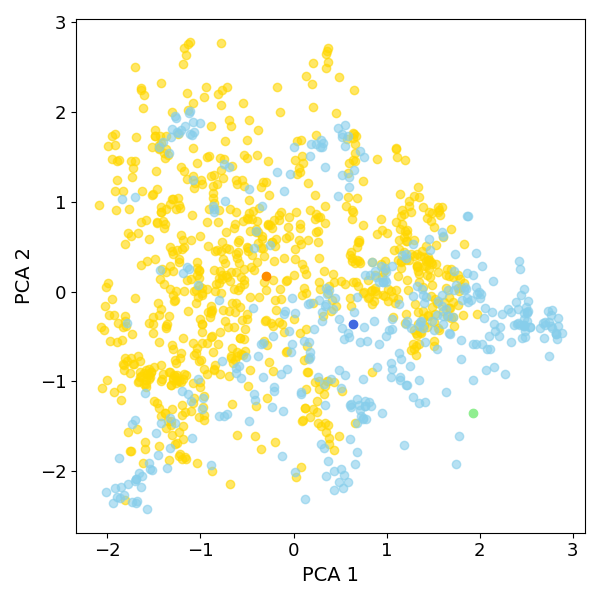

In [55]:
fig = plt.figure(figsize=(6,6))
ticks_font = 13
label_font = 14
plt.scatter(related_set_a_mf_pca[:,0],related_set_a_mf_pca[:,1],label='olefins in related set a',c='gold',alpha=0.6)
plt.scatter(related_set_a_mf_pca[:,0].mean(),related_set_a_mf_pca[:,1].mean(),c='darkorange')
plt.scatter(related_set_b_mf_pca[:,0],related_set_b_mf_pca[:,1],label='olefins in related set b',c='skyblue',alpha=0.6)
plt.scatter(related_set_b_mf_pca[:,0].mean(),related_set_b_mf_pca[:,1].mean(),c='royalblue')
plt.scatter(target_mf_pca[0],target_mf_pca[1],label='target olefin',c='lightgreen')
plt.xlabel('PCA 1',fontsize=label_font)
plt.ylabel('PCA 2',fontsize=label_font)
plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.tight_layout()